# DLVC HW0 Report

* Name: Hao-Cheng Lo
* ID: D08227104
* Dept.: PSY

* Collaborators: me, myself, and I, [EigenFaces](https://towardsdatascience.com/eigenfaces-face-classification-in-python-7b8d2af3d3ea)

## Data Preprocessing

In [1]:
# import required libraries
import os
import numpy as np
import pandas as pd

import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.decomposition import PCA
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

In [2]:
def hw0_imread(person, i):
    '''
    Read single img of perion_image_
    '''
    return cv2.imread(os.path.join("p1_data", "{}_{}.png".format(person, i)), 0)


def img_dataset(persons = 40, imgs = 10, ratio = 0.9):
    '''
    Construct a dataset and split them as training set and testing set
    '''
    
    # before this cutoff is training set, otherwise testing set
    train_cutoff = int(imgs * ratio)
    
    # training set
    X = np.array([hw0_imread(p, i) for p in range(1, persons+1) for i in range(1, train_cutoff+1)])
    Y = np.array([p for p in range(1, persons+1) for _ in range(1, train_cutoff+1)])
    
    print("Shape of training set (before flattening):", X.shape)
    
    # testing set
    X_test = np.array([hw0_imread(p, i) for p in range(1, persons+1) for i in range(train_cutoff+1, imgs+1)])
    Y_test = np.array([p for p in range(1, persons+1) for _ in range(train_cutoff+1, imgs+1)])
    
    print("Shape of testing set (before flattening):", X_test.shape)
    
    # flattening
    # reshape(target_first_dim, res_dim)
    X, X_test = X.reshape(persons * train_cutoff, -1), X_test.reshape(persons * (imgs-train_cutoff), -1)
    
    print("Shape of training set (after flattening):", X.shape)
    print("Shape of testing set (after flattening):", X_test.shape)
    
    return X, Y, X_test, Y_test

In [3]:
X, Y, X_test, Y_test = img_dataset()

Shape of training set (before flattening): (360, 56, 46)
Shape of testing set (before flattening): (40, 56, 46)
Shape of training set (after flattening): (360, 2576)
Shape of testing set (after flattening): (40, 2576)


In [4]:
X

array([[ 88,  88,  90, ..., 138, 142, 134],
       [ 87,  90,  95, ..., 124, 120,  88],
       [ 92,  92,  88, ..., 165, 146, 151],
       ...,
       [128, 128, 128, ...,  91,  92,  93],
       [122, 123, 124, ...,  38,  40,  38],
       [120, 119, 121, ...,  95,  92,  90]], dtype=uint8)

## Problem 1
(20%) Perform PCA on the training set. Plot the mean face and the first four eigenfaces

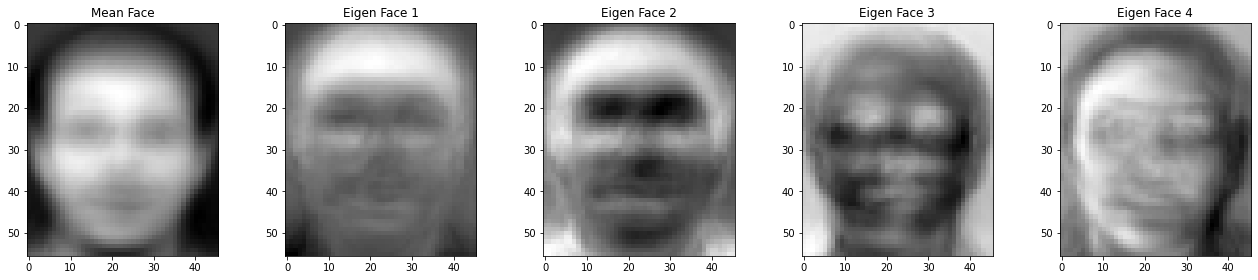

In [5]:
# mean face
mean_face_v = np.mean(X, axis=0)

# pca
pca = PCA()
pca_result = pca.fit(X - mean_face_v)

# img preparing 
imgs = np.concatenate([np.array([mean_face_v]), pca_result.components_[:5]])
names = ["Mean Face", "Eigen Face"]

# drawing drawing drawing
plt.figure(figsize=(20,8))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(imgs[i].reshape(56,46), cmap='gray')
    plt.title(names[0]) if i == 0 else  plt.title("{} {}".format(names[1],i))

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

## Problem 2 and Problem 3
(20%) If the last digit of your student ID number is odd, take person2image1. If the last digit of
your student ID number is even, take person8image1. Project it onto the PCA eigenspace you
obtained above. Reconstruct this image using the first n = 3, 50, 170, 240, 345 eigenfaces. Plot
the five reconstructed images.

(20%) For each of the five images you obtained in 2., compute the mean squared error (MSE)
between the reconstructed image and the original image. Record the corresponding MSE values
in your report.

In [6]:
# setting
last_digit = 4
person = 8 if last_digit%2 == 0 else 2
idx = 1
target_img = hw0_imread(person, idx).reshape(1, -1)
print(target_img)

[[128 129 129 ...  47  39  47]]


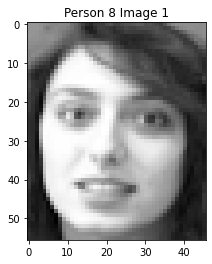

In [7]:
# showcase
plt.title("Person {} Image {}".format(person, idx))
plt.imshow(target_img.reshape(56,46), cmap="gray")
plt.show()

In [9]:
# Project img to Eigenspace (each eigenvector)
projected_coor = pca.transform(target_img - mean_face_v)
# there are total 360 dim and its coordinates
print(projected_coor.shape)
# eigen space: how many eigen vectors
es = [3, 50, 170, 240, 345]

(1, 360)


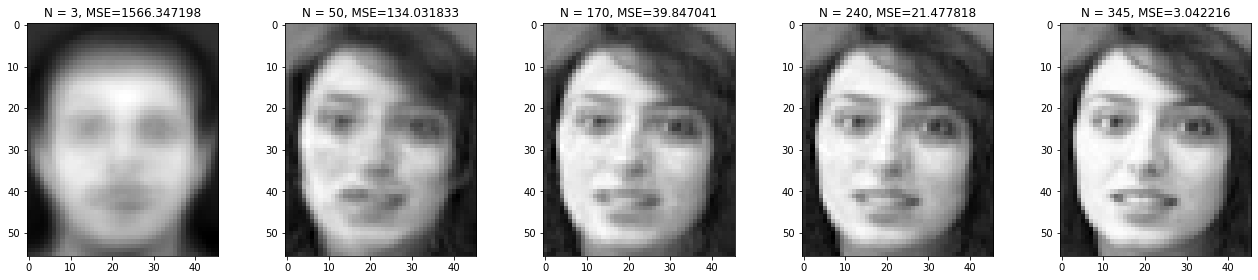

In [12]:
# calculate and rendering
plt.figure(figsize=(20,8))
for i in range(len(es)):
    e = es[i]
    # linear combination of eigenvector of the target_img
    reconstruction_img = np.dot(projected_coor[:,:e], pca_result.components_[:e]) + mean_face_v
    # mean square error
    mean_square_error = np.mean((reconstruction_img - target_img)**2)
    
    # plotting
    plt.subplot(1, 5, i+1)
    plt.title("N = {:d}, MSE={:f}".format(e, mean_square_error))
    plt.imshow(reconstruction_img.reshape(56,46), cmap = "gray")

plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25, wspace=0.35)
plt.show()

## Problem 4
(20%) Now, apply the k-nearest neighbors algorithm to classify the testing set images. First,
you will need to determine the best k and n values by 3-fold cross-validation. For simplicity,
the choices for such hyperparameters are $k = \{1, 3, 5\}$ and $n = \{3, 50, 170\}$. Show the cross validation results and explain your choice for (k, n).

In [13]:
# proj whole training set to eigen space: linear combination of eigen vectors
proj_X = pca_result.transform(X - mean_face_v)

In [14]:
# ===================KNN===================
params = {'n_neighbors':[1,3,5],
         }
knn = KNeighborsClassifier()
knn_clf_cv = GridSearchCV(knn, params, cv=3, verbose=True)

In [15]:
# ===================Training and Check CV score===================
n = [3, 50, 170]
col_names_a = []
col_names_b = []
cv_results = []
for i in n:
    
    col_names_a += ["n = {}".format(i)]*3
    col_names_b += ["k = 1","k = 3","k = 5"]
    
    knn_clf_cv.fit(proj_X[:,:i], Y)
    cv_results += knn_clf_cv.cv_results_['mean_test_score'].tolist()

    
header = [np.array(col_names_a), np.array(col_names_b)] 
df = pd.DataFrame(np.array([cv_results]), columns = header, index = ['cv_score'])
df

Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Fitting 3 folds for each of 3 candidates, totalling 9 fits


n = 3                        n = 50                   n = 170  \
         k = 1     k = 3     k = 5     k = 1 k = 3     k = 5     k = 1   
cv_score  0.65  0.611111  0.561111  0.961111   0.9  0.847222  0.955556   

                              
             k = 3     k = 5  
cv_score  0.888889  0.822222

Best hyperparameters (based on above best CV_score): $n = 50,\ k = 1$

## Problem 5
(20%) Use your hyperparameter choice in 4. and report the recognition rate of the testing set.

In [16]:
# proj whole training set to eigen space: linear combination of eigen vectors
proj_X_test = pca_result.transform(X_test - mean_face_v)
n, k = 50, 1

In [17]:
# training
based_cv_best_knn = KNeighborsClassifier(n_neighbors=k)
based_cv_best_knn.fit(proj_X[:,:n], Y)

# testing
pred = based_cv_best_knn.predict(proj_X_test[:,:n])
print("Acc: {}".format(accuracy_score(pred, Y_test)))

Acc: 0.925


### Complementary analysis

In [18]:
# experiment on second tier parameters
n, k = 170, 1

# training
based_cv_best_knn = KNeighborsClassifier(n_neighbors=k)
based_cv_best_knn.fit(proj_X[:,:n], Y)

# testing
pred = based_cv_best_knn.predict(proj_X_test[:,:n])
print("Acc: {}".format(accuracy_score(pred, Y_test)))

Acc: 0.95
